In [51]:
%load_ext autoreload 
%autoreload 2 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [52]:
import random
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec # for subplots
import pandas as pd
import numpy as np
import seaborn as sns
import seaborn.objects as so
import tensorflow as tf


from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from tensorflow.keras.preprocessing.sequence import pad_sequences




from src.utilities.pandas_helpers import get_features


plt.rcParams['path.simplify_threshold'] = 1.0
plt.rcParams['agg.path.chunksize'] = 2000 


### Objectives 
* Dim reduction
* PCA, UMAP and tSNE

In [53]:
# DATA_PATH = '/projects/p31961/gaby_data/aggregated_data/data_pipeline_full_dataset/datasets/full_dataset.parquet.gzip'
DATA_PATH = "/Users/michaelschaid/interm_data_transfer/full_dataset.parquet.gzip" #local

In [54]:
data = pd.read_parquet(DATA_PATH)
# data = data[::1000].reset_index(drop=True) # subsample for speed

In [101]:
# data.assign(mouse_id = lambda x: x.mouse_id.astype('category'),
mouse_cols =  [col for col in data.columns if 'mouse' in col]
sensor_cols = [col for col in data.columns if 'sensor' in col]
event_cols = [col for col in data.columns if 'event' in col]


def rehape_df(df):
    return (df
            .assign(sensor = lambda df_: df_[sensor_cols].idxmax(axis = 1).str.replace('sensor_', '').astype('category'),
                   event = lambda df_: df_[event_cols].idxmax(axis = 1).str.replace('event_', '').astype('category'),
                   mouse = lambda df_: df_[mouse_cols].idxmax(axis=1).str.replace('mouse_id_', '').astype('int')
            )
            .drop(columns = mouse_cols + sensor_cols + event_cols)
    )
    
reshape_df = rehape_df(data)
reshape_df

,time,sex_M,day,trial,trial_count,learning_phase,latency,signal,sensor,event,mouse
0,-25.000000,0,5,0,115,0,0.00,-0.155359,1,cue,12
1,-24.901531,0,5,0,115,0,0.00,-0.420553,1,cue,12
2,-24.803064,0,5,0,115,0,0.00,-1.592294,1,cue,12
3,-24.704596,0,5,0,115,0,0.00,-1.268734,1,cue,12
4,-24.606127,0,5,0,115,0,0.00,-0.210176,1,cue,12
...,...,...,...,...,...,...,...,...,...,...,...
5858795,19.606127,0,4,1,87,0,7.54,0.299603,0,escape,1
5858796,19.704596,0,4,1,87,0,7.54,-0.249408,0,escape,1
5858797,19.803064,0,4,1,87,0,7.54,-0.486369,0,escape,1
5858798,19.901531,0,4,1,87,0,7.54,-0.146374,0,escape,1


# Dimentionality reduction

## PCA  - by day



In [116]:
def pca_by_cat(df, group_col):
    
    def convert_to_cat_codes(df):
        for col in df.select_dtypes('category').columns:
            df[col] = df[col].cat.codes
        return df

    def drop_groups_standardarized(df, group_col):
        return  StandardScaler().fit_transform(df.drop(columns = group_col).values)
    
    # convert to category columns to codes
    numerical_data = convert_to_cat_codes(df)
    # standardize data
    standardized_data = drop_groups_standardarized(numerical_data, group_col)
    
    #run pca
    pca = PCA()
    pca_components = pca.fit_transform(standardized_day_data)
    
    # create df with pca components and group column for visualization
    pca_df_w_group = (pd.DataFrame(data = pca_components, columns = [f'PC_{i}' for i in range(pca_components.shape[1])])
              .assign(group = df[group_col])
              .rename(columns = {'group': group_col})
              )
    # return pca object, pca components, and pca df
    return pca, pca_components, pca_df_w_group

def plot_pca(df, group):
    ''' plots scree plot and pca components for first two components diven group column'''
    fig, (ax1, ax2)= plt.subplots(figsize=(10,5), nrows = 1, ncols = 2 )
    ax1.plot(day_pca.explained_variance_ratio_, linewidth=2, color = 'k', marker = 'o', markersize = 6)
    ax1.set_xlabel("Principal Component")
    ax1.set_ylabel("Explained Variance Ratio")
    ax1.set_title("Scree Plot")
    sns.despine()
    ax1.grid(True)

    sns.scatterplot(data = df, x = 'PC_0', y = 'PC_1', hue = group, alpha = 0.5, size = 0.5, ax = ax2)
    plt.show()

In [117]:
day_pca, day_pca_components, day_pca_df_w_group = pca_by_cat(reshape_df, 'day')

/Users/michaelschaid/opt/anaconda3/envs/enigma/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


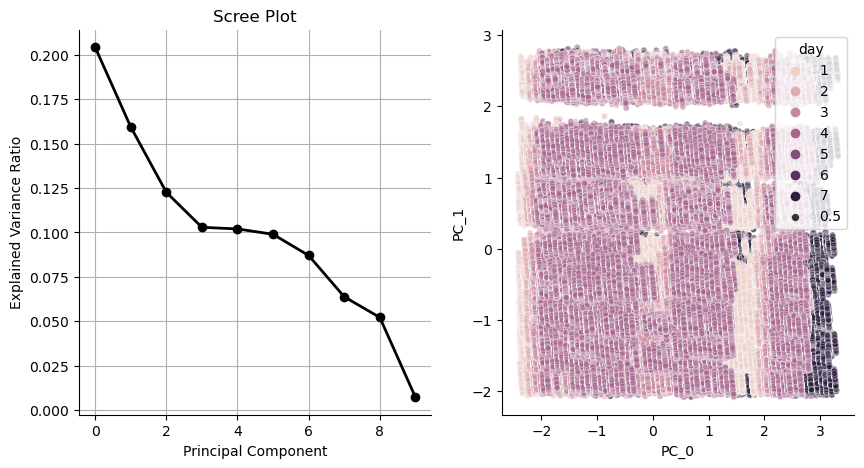

In [121]:
plot_pca(day_pca_df_w_group, 'day')

In [124]:
day_hot_pca, day_hot_pca_components, day_hot_pca_df_w_group = pca_by_cat(data, 'day')

/Users/michaelschaid/opt/anaconda3/envs/enigma/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


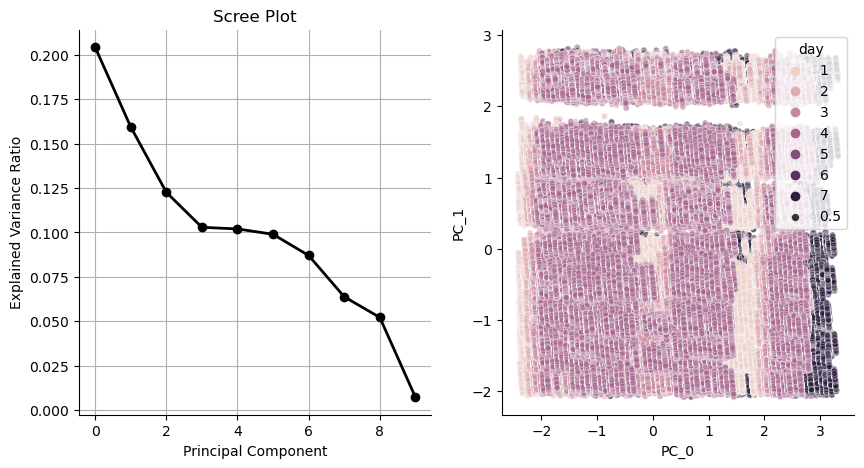

In [125]:
plot_pca(day_hot_pca_df_w_group, 'day')

In [130]:

stnd = StandardScaler().fit_transform(data.drop(columns = ['day'].values)
new_pca = PCA()
day_pca_components = new_pca.fit_transform(stnd)
pca_df_w_group = (pd.DataFrame(data = day_pca_components, columns = [f'PC_{i}' for i in range(day_pca_components.shape[1])])
            .assign(day = data['day']))



<Axes: xlabel='PC_0', ylabel='PC_1'>

/Users/michaelschaid/opt/anaconda3/envs/enigma/lib/python3.11/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/michaelschaid/opt/anaconda3/envs/enigma/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


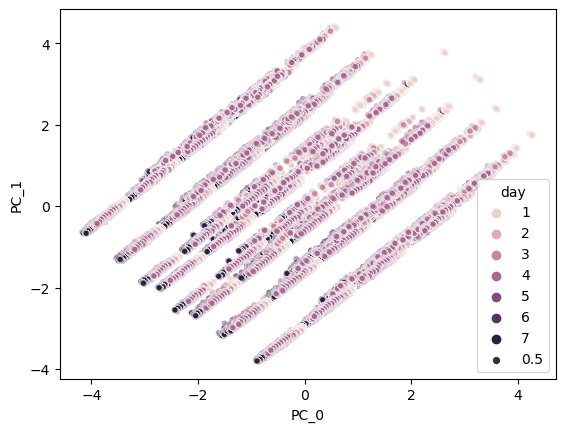

In [131]:
sns.scatterplot(data = pca_df_w_group, x = 'PC_0', y = 'PC_1', hue = 'day', alpha = 0.5, size = 0.5)

# PCA by event

/Users/michaelschaid/opt/anaconda3/envs/enigma/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


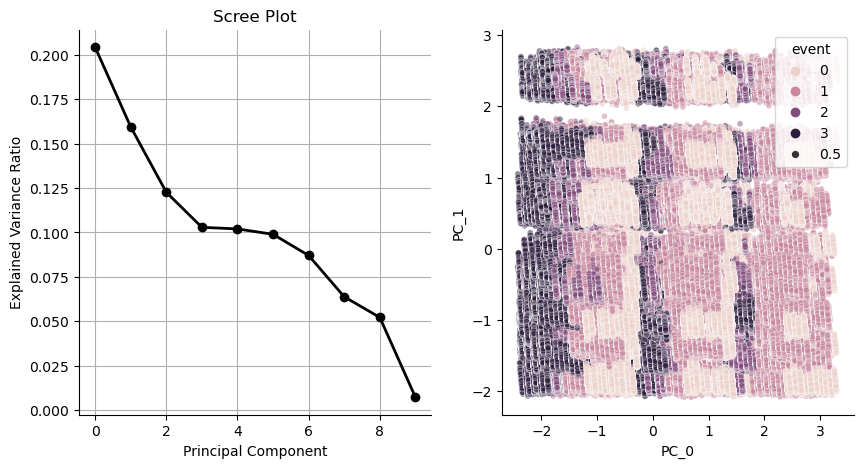

In [132]:
event_pca, event_pca_components, event_pca_df_w_group = pca_by_cat(reshape_df, 'event')
plot_pca(event_pca_df_w_group, 'event')

 # PCA by trial count

In [ ]:
trial_pca, trial_pca_components, trial_pca_df_w_group = pca_by_cat(reshape_df, 'trial_count')
plot_pca(event_pca_df_w_group, 'trial_count')

In [10]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)

In [46]:
std_ds = standardized_day_data[::1000] 
std_ds

array([[-1.72842178, -1.34347727, -1.39708086, ..., -0.30128582,
         3.70459762, -0.28129784],
       [-1.09301663, -1.34347727, -1.14476226, ..., -0.30128582,
         3.70459762, -0.28129784],
       [-0.45761163, -1.34347727, -0.89244366, ..., -0.30128582,
         3.70459762, -0.28129784],
       ...,
       [ 1.3427028 ,  0.74433712,  0.99994586, ..., -0.30128582,
        -0.26993485, -0.28129784],
       [-1.48636276,  0.74433712, -1.39708086, ..., -0.30128582,
        -0.26993485,  3.55495086],
       [-0.85095761, -1.34347727, -1.39708086, ..., -0.30128582,
        -0.26993485, -0.28129784]])

In [47]:
tsne_day= tsne.fit_transform(std_ds)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5859 samples in 0.003s...
[t-SNE] Computed neighbors for 5859 samples in 0.195s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5859
[t-SNE] Computed conditional probabilities for sample 2000 / 5859
[t-SNE] Computed conditional probabilities for sample 3000 / 5859
[t-SNE] Computed conditional probabilities for sample 4000 / 5859
[t-SNE] Computed conditional probabilities for sample 5000 / 5859
[t-SNE] Computed conditional probabilities for sample 5859 / 5859
[t-SNE] Mean sigma: 1.692221
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.870617
[t-SNE] KL divergence after 300 iterations: 1.621417


In [48]:
tsne_day_df = (pd.DataFrame(data = tsne_day, columns = ['tsne_0', 'tsne_1'])
                            .assign(day = data[::1000].reset_index()['day'])
)

In [49]:
tsne_day_df

,tsne_0,tsne_1,day
0,-5.570351,-5.044075,5
1,-5.551271,-5.040698,5
2,-5.524395,-5.044523,5
3,-5.491864,-5.042799,5
4,-5.434439,-5.043093,5
...,...,...,...
5854,-1.709047,-1.076720,4
5855,-1.685163,-1.044882,4
5856,-1.684898,-1.056249,4
5857,5.377541,-12.640015,4


<Axes: xlabel='tsne_0', ylabel='tsne_1'>

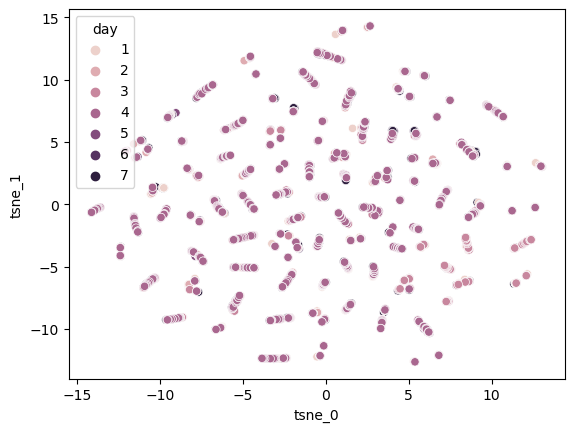

In [50]:
sns.scatterplot(data = tsne_day_df, x = 'tsne_0', y = 'tsne_1', hue = 'day')